In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import accuracy_score
enc = LabelEncoder()
mms = MinMaxScaler()
sns.set_style('darkgrid')

In [2]:
file_paths = []

emotions_encoder = {

    '01': 'Neutral',
    '02': 'Calm',
    '03': 'Happy',
    '04': 'Sad',
    '05': 'Angry',
    '06': 'Fearful',
    '07': 'Disgust',
    '08': 'Surprised'

}

emotions = []

folder = '/home/brillard/bricode/PY/PRML Project_self/ravdess-data'

for i in range(24):

    subfolder = f"Actor_{str(i+1).zfill(2)}"

    directory = os.path.join(folder,subfolder)

    for filename in os.listdir(directory):

        path_file = os.path.join(directory,filename)

        file_paths.append(path_file)

        emotions.append(emotions_encoder[(filename.split('-')[2])])

Data = pd.DataFrame(np.c_[file_paths,emotions],columns=['Path','Emotion'],).sample(frac=1).reset_index(inplace=False).drop(columns='index')

Data.head()


,Path,Emotion
0,/home/brillard/bricode/PY/PRML Project_self/ra...,Angry
1,/home/brillard/bricode/PY/PRML Project_self/ra...,Surprised
2,/home/brillard/bricode/PY/PRML Project_self/ra...,Sad
3,/home/brillard/bricode/PY/PRML Project_self/ra...,Happy
4,/home/brillard/bricode/PY/PRML Project_self/ra...,Angry


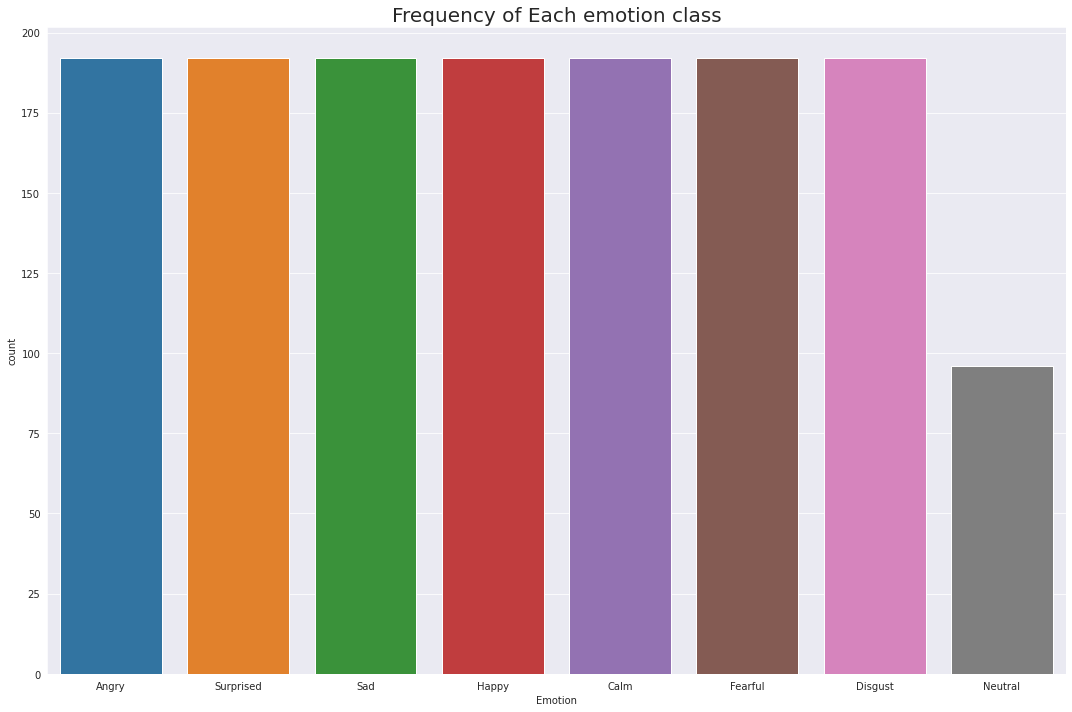

In [3]:
plt.figure("The counts of Each emotion category in Dataset",(15,10))

sns.countplot(x = Data.Emotion)

plt.title("Frequency of Each emotion class",fontdict={'fontsize': 20})

plt.tight_layout()

plt.show()

In [4]:
def wavplot(path,figsize=(15,5)):

    aud, sr = librosa.load(path=path)

    plt.figure(figsize=figsize)

    plt.plot(aud)

    plt.tight_layout()

    plt.show()

def specplot(path,figsize=(15,5)):

    aud, sr = librosa.load(path=path)

    X = abs(librosa.stft(aud))

    db = librosa.amplitude_to_db(X)

    plt.figure(figsize=figsize)

    librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='hz')

    plt.show()

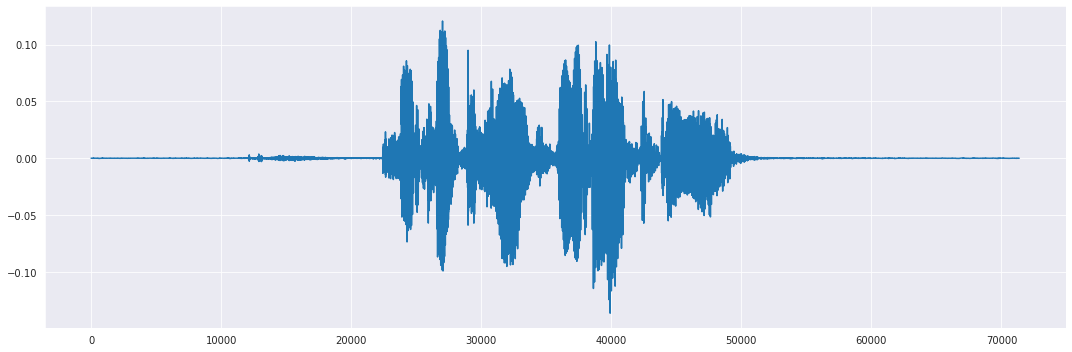

In [5]:
wavplot(Data.Path[1])

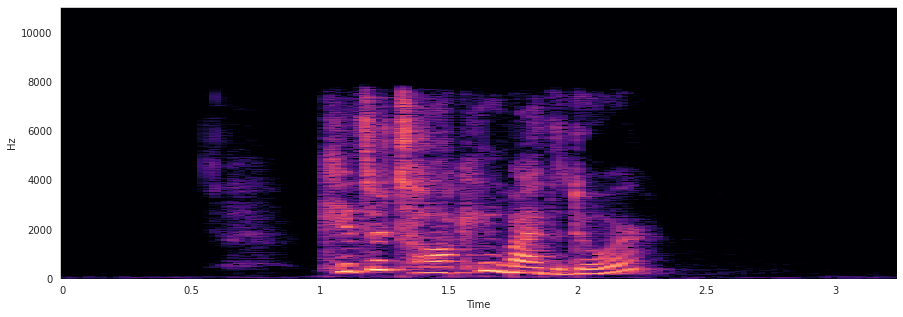

In [6]:
specplot(Data.Path[1])

In [7]:
aud, sr = librosa.load(Data.Path[9])

X = abs(librosa.stft(aud))

mel = librosa.feature.mfcc(y=aud)

Chroma = librosa.feature.chroma_stft(S=X,sr=sr)

Chr = np.argmax(Chroma,axis=0).tolist()

freq = np.zeros(12,dtype=int)

for i in range(12):

    freq[i] += Chr.count(i+1)



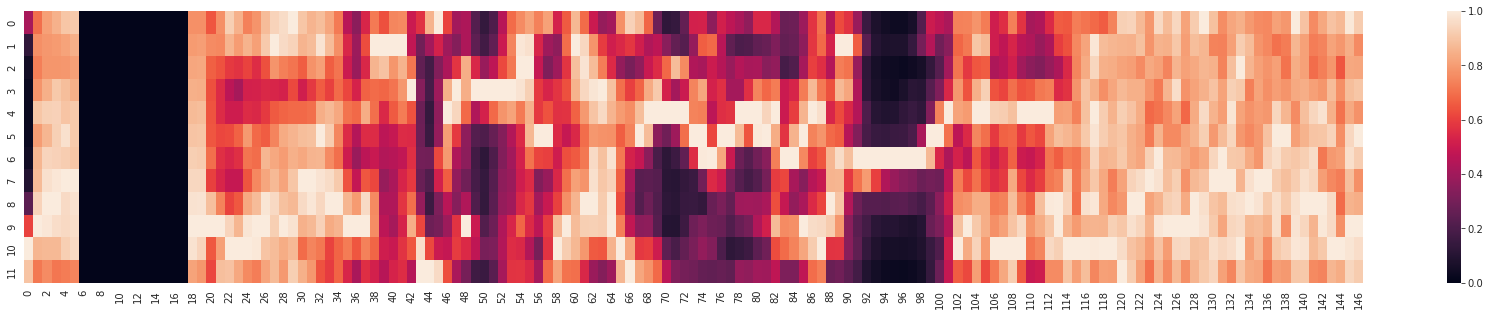

In [8]:
plt.figure(figsize=(30,5))

sns.heatmap(Chroma)

plt.show()

In [9]:
Chroma.shape

(12, 147)

In [10]:
class Augment():

    def __init__(self):

        pass

    def load(self,path):

        aud, sr = librosa.load(path=path)

        self.aud = aud

        self.sampling_rate = sr

    def noise(self,path):

        self.load(path)

        aud = self.aud
        
        noise_amp = 0.035*np.random.uniform()*np.amax(aud)
        
        aud = aud + noise_amp*np.random.normal(size=aud.shape[0])
        
        return aud

    def time_stretch(self,path, rate=0.6):

        self.load(path)

        aud = self.aud

        return librosa.effects.time_stretch(aud, rate)

    def time_roll(self,path):

        self.load(path)

        aud = self.aud

        shift_range = int(np.random.uniform(low=-5, high = 5)*1000)

        return np.roll(aud, shift_range)

    def pitch(self,path, pitch_factor=0.6):

        self.load(path)

        aud = self.aud

        sampling_rate = self.sampling_rate

        return librosa.effects.pitch_shift(aud, sampling_rate, pitch_factor)

    def get_methods(self,path,methods=[]):

        noised = []

        stretched = []

        rolled = []

        pitched = []

        for path in Data.Path:

            noised.append(self.noise(path))

            stretched.append(self.time_stretch(path))

            rolled.append(self.time_roll(path))

            pitched.append(self.pitch(path))

        return noised,stretched,rolled,pitched


aug = Augment()

In [11]:
class Preprocess():

    def __init__(self,sr=None):

        self.sampling_rate = sr

    def load(self,path):

        aud,sr = librosa.load(path=path)

        self.sampling_rate = sr

        return aud

    def get_zcr(self,aud):

        Z = np.mean(librosa.feature.zero_crossing_rate(y=aud),axis=0)

        return Z

    def get_mfcc(self,aud):

        M = np.mean(librosa.feature.mfcc(y=aud),axis=0)

        return M

    def get_mel(self,aud):

        Me = np.mean(librosa.feature.melspectrogram(y=aud,sr=self.sampling_rate),axis=0)

        return Me

    def get_chroma(self,aud):

        X = abs(librosa.stft(aud))

        Chr = np.argmax(librosa.feature.chroma_stft(S=X,sr=self.sampling_rate),axis=0).tolist()

        freq = np.zeros(12,dtype=int)

        for i in range(12):

            freq[i] += Chr.count(i+1)

        return freq

    def get_meansquared(self,aud):

        me = np.sqrt(np.mean(aud**2))

        return me

    def get_spread(self,aud):

        var = np.var(aud)

        return var

    def extract_features(self,aud):

        # var = int(self.get_spread(aud))

        # me = int(self.get_meansquared(aud))

        Chr = self.get_chroma(aud).ravel()

        # Me = self.get_mel(aud).ravel()

        # M = self.get_mfcc(aud).ravel()

        # Z = self.get_zcr(aud).ravel()

        # final = np.r_[Chr,Me,me,var,M,Z]

        return Chr

feat = Preprocess()

In [12]:
x1 = []

for path in Data.Path:

    x1.append(list(feat.extract_features(feat.load(path))))

X = np.array(x1)

Y = enc.fit_transform(emotions)

xtrain,xtest,ytrain,ytest = train_test_split(X,Y,shuffle=True,random_state=42,train_size=0.7)


### Multinomial Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
import pickle

mb = MultinomialNB()

mb.fit(xtrain,ytrain)

pickle.dump(mb, open('model_mb.pkl', 'wb'))

In [18]:
model = pickle.load(open('model_mb.pkl', 'rb'))

res = model.predict(xtest)

accuracy_score(res,ytest)

0.12471131639722864

In [16]:
from tensorflow.python.keras.layers import Dense,Conv1D,MaxPooling1D
